In [39]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rxitect.scorers import rascore as rs

In [21]:
rascore = rs.load_rascore_model(ckpt_filepath="../models/rascore_26102022.ckpt")

 [*] Loading checkpoint from ../models/rascore_26102022.ckpt succeed!
Checkpoint restored!


In [31]:
fcfp = torch.tensor(rs.mol2fcfp(MolFromSmiles("CCC")), dtype=torch.float)

In [32]:
rascore(fcfp)

tensor([1.], grad_fn=<SigmoidBackward0>)

<AxesSubplot: xlabel='Score', ylabel='Label'>

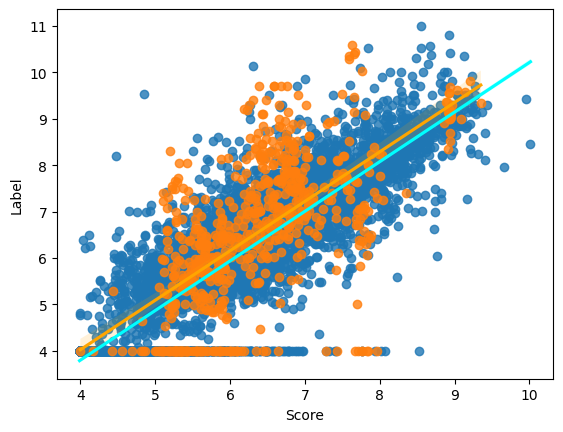

In [255]:
rf_a2a_cv = pd.read_csv("../models/RF_REG_CHEMBL251.cv.tsv", sep="\t")
rf_a2a_ind = pd.read_csv("../models/RF_REG_CHEMBL251.ind.tsv", sep="\t")
df_cv = rf_a2a_cv#.query("`Label`>=4")
df_ind = rf_a2a_ind#.query("`Label`>=4")
sns.regplot(x=df_cv.Score, y=df_cv.Label, line_kws={"color":"aqua"})
sns.regplot(x=df_ind.Score, y=df_ind.Label, line_kws={"color":"orange"})

In [256]:
from sklearn.metrics import r2_score

In [257]:
r2_score(y_pred=df_cv.Score, y_true=df_cv.Label)

0.787191039239844

In [258]:
max(df_cv.Score)

10.015239999999984

In [259]:
max(df_cv.Label)

11.0

In [261]:
chembl_code = 226
rf_a2a_cv = pd.read_csv(f"../models/RF_REG_CHEMBL{chembl_code}.cv.tsv", sep="\t")
rf_a2a_ind = pd.read_csv(f"../models/RF_REG_CHEMBL{chembl_code}.ind.tsv", sep="\t")
df_cv = rf_a2a_cv.query("`Label`>=4")
df_ind = rf_a2a_ind.query("`Label`>=4")
np.percentile(a=df_cv.Label, q=95)

8.626999999999999

In [98]:
pair = [
    "Target_ChEMBL_ID",
    "Smiles",
    "pChEMBL_Value",
    "Comment",
    "Standard_Type",
    "Standard_Relation",
    "Document_Year",
]
ligand_path = "../data/ligand_raw.tsv"
df = pd.read_table(ligand_path).dropna(subset=pair[1:2])

In [103]:
a2a_known = df.query("`Target_ChEMBL_ID`=='CHEMBL251'")["pChEMBL_Value"].dropna()

In [106]:
from sklearn import preprocessing

In [114]:
scaler = preprocessing.MinMaxScaler()

In [115]:
a2a_scaler = scaler.fit(a2a_known.to_numpy().reshape(-1, 1))

In [120]:
a2a_scaler.data_min_

array([4.])

In [124]:
a2a_known_scaled

array([[0.30714286],
       [0.28285714],
       [0.17571429],
       ...,
       [0.24714286],
       [0.25857143],
       [0.45857143]])

In [125]:
a2a_known

6        6.15
7        5.98
10       5.23
11       5.39
17       5.02
         ... 
54831    7.96
54834    5.27
54835    5.73
54839    5.81
54840    7.21
Name: pChEMBL_Value, Length: 5851, dtype: float64

In [135]:
a2a_known_scaled.shape

(5851, 1)

In [191]:
from pyprojroot import here
from sklearn.preprocessing import MinMaxScaler

def preprocess_pchembl_data(target_chembl_id: str = "CHEMBL251", year_split: int = 2015) -> pd.DataFrame:
    scaler = MinMaxScaler()
    cols = ['Target_ChEMBL_ID', 'Smiles', 'pChEMBL_Value', 'Comment',
            'Standard_Type', 'Standard_Relation', 'Document_Year']
    df = pd.read_table(here() / "data/ligand_raw.tsv", usecols=cols)
    df = df.query(f"`Target_ChEMBL_ID`=='{target_chembl_id}'")
    scaler.fit(df["pChEMBL_Value"].to_numpy().reshape(-1, 1))
    df["pChEMBL_Value"] = scaler.transform(df["pChEMBL_Value"].to_numpy().reshape(-1, 1))
    df = df.set_index("Smiles")
    
    by_year = df[["Document_Year"]].groupby("Smiles").min().dropna()
    tmp_test_idcs = by_year[by_year["Document_Year"] > year_split].index
    by_pval = df["pChEMBL_Value"].groupby("Smiles").mean().dropna()

    comments = df[(df.Comment.str.contains('Not Active') == True)]
    inhibits = df[(df.Standard_Type == 'Inhibition') & df.Standard_Relation.isin(['<', '<='])]
    relations = df[df.Standard_Type.isin(['EC50', 'IC50', 'Kd', 'Ki']) & df.Standard_Relation.isin(['>', '>='])]
    binary = pd.concat([comments, inhibits, relations], axis=0)
    binary = binary[~binary.index.isin(by_pval.index)]
    binary["pChEMBL_Value"] = 3.99
    binary["pChEMBL_Value"] = scaler.transform(binary["pChEMBL_Value"].to_numpy().reshape(-1, 1))
    binary = binary["pChEMBL_Value"].groupby(binary.index).first()
    # df = by_pval.append(binary)
    df = pd.concat([by_pval, binary])
    df = df.sample(len(df))
    
    test_idcs = list(set(df.index).intersection(tmp_test_idcs))
    # test_data = df.loc[test_idcs].dropna()
    print(df)
    test_data = df.loc[test_idcs].dropna()
    train_data = df.drop(test_data.index)
    
    return train_data, test_data

def train_pchembl_predictor():
    pass

In [193]:
# %debug
train, test = preprocess_pchembl_data()

Smiles
CC(=O)OCC(CCn1cnc2cnc(N)nc21)COC(C)=O                                               -0.001429
CCc1ccc(-c2nc(N)c3cc(Cc4ccccc4)sc3n2)o1                                              0.472857
C[C@@H]1CC[C@H]2[C@@H](C)C(=O)O[C@@H]3O[C@]4(C)CC[C@@H]1[C@]32OO4                   -0.001429
CCCNC(=O)c1cnn(-c2nc(N[C@H]3CCCO3)c3ncn([C@@H]4O[C@H](CO)[C@@H](O)[C@H]4O)c3n2)c1   -0.001429
CN(C)c1nc(N)nc(-c2sc(NC(=O)c3ccccc3)nc2-c2ccccc2)n1                                  0.355714
                                                                                       ...   
Nc1nc(C#CC(O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O                     0.592857
COc1ccccc1-c1nc(N)nc2c1C(=O)c1ccccc1-2                                               0.498571
CC(C)CCn1cc2c(nc(NC(=O)C(c3ccccc3)c3ccccc3)n3nc(-c4ccco4)nc23)n1                     0.400000
CNc1nc(-n2cc(CCO)nn2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O                     -0.001429
Nc1nc2nn(Cc3ccc(C4(C(F)(F)F)N=N4)cc3)cc2c2nc(-c3ccco3

/tmp/ipykernel_11753/2138229358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pChEMBL_Value"] = scaler.transform(df["pChEMBL_Value"].to_numpy().reshape(-1, 1))


In [196]:
from sklearn.ensemble import RandomForestRegressor

In [197]:
from rxitect.scorers.a2ascore import Predictor

In [205]:
Predictor.calc_fp([MolFromSmiles("CC(C)CCn1cc2c(nc(NC(=O)C(c3ccccc3)c3ccccc3)n3nc(-c4ccco4)nc23)n1")])

array([[  0.    ,   1.    ,   0.    , ..., 103.14  , 190.    , 144.5867]])

In [213]:
X_train, y_train = Predictor.calc_fp([Chem.MolFromSmiles(smi) for smi in train.index]), train.values

In [223]:
X_test, y_test = Predictor.calc_fp([Chem.MolFromSmiles(smi) for smi in test.index]), test.values

In [248]:
rf = RandomForestRegressor(n_estimators=1_000, n_jobs=-1)

In [251]:
rf.fit(X_train, y_train, sample_weight=[1 if v >= 0 else 0.1 for v in y_train])

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [220]:
rf.predict(X_train)

array([-0.00142857,  0.47285714, -0.00142857, ...,  0.49857143,
        0.4       , -0.00142857])

In [252]:
X_test_pos, y_test_pos = X_test[y_test >= 0], y_test[y_test >= 0]

0.37235517092685944

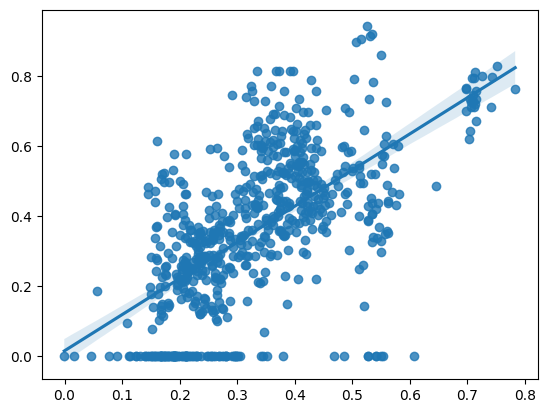

In [254]:
sns.regplot(x=rf.predict(X_test), y=y_test)
r2_score(y_pred=rf.predict(X_test), y_true=y_test)

In [233]:
preds = rf.predict(X_train)

In [243]:
preds[preds <= 0] = 1e-20

In [244]:
preds

array([0.0660357 , 0.46984714, 0.00983929, ..., 0.53800048, 0.41969571,
       0.01184405])